# <span style='color:blue'> CDS 522 Text and Speech Analytics Project : </span>
## <span style='color:blue'> Text Analytics for Suicidal Thoughts </span>

**Prepared by: 
Chin Yi Xiang,
Ling Hui Ting**

## Import Required Packages

In [1]:
# import required packages
#warnings :)
import warnings
warnings.filterwarnings('ignore')

# for df purpose
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

# for text processing
import nltk
import re
import string
from autocorrect import Speller


# for graph plotting / visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#for storing intermediate results
import pickle

# for notebook function
from IPython.display import display, clear_output
import time

## Data Cleaning

* Getting Data
* Combine Data
* Treating Missing/Duplicate Values

### Getting the Data

* Scraping data from subreddit: Suicidal_Thoughts
* Download from Kaggle : Suicide Notes

In [2]:
reddit =pd.read_csv('data/post_data.csv', header= 0)
kaggle = pd.read_csv('data/kaggle_test.csv')

In [3]:
reddit.head(2)

,id,url,url_id,url_title,author,upvote_ratio,score,time_created,num_gold,num_comments,category,text,main_link,flairs
0,1,https://www.reddit.com/r/Suicidal_Thoughts/com...,k1gid0,guess_i_got_it,ayu5hh,0.95,18,2020-11-26 22:53:11,0,0,NaN,NaN,NaN,NaN
1,2,https://www.reddit.com/r/memes/comments/k1daj2...,k1daj2,hold_the_fuck_up,yosuf123321,0.90,24882,2020-11-26 18:58:41,0,194,NaN,NaN,NaN,NaN


In [4]:
kaggle.head(2)

,id,text
0,1,I have to put this in writing somehow so I sti...
1,2,I've made my peace with the fact that I'm goin...


### Combine the file 

* Combine df from Kaggle and Subreddit

In [5]:
df = reddit['text'].append(kaggle['text'], ignore_index=True)
df

0                                                     NaN
1                                                     NaN
2       I fucking HATE the holiday season. First is Th...
3       Dm me here or add me on discord if you want to...
4                                                     NaN
                              ...                        
1485    Since I was 9 I felt depressed and almost took...
1486    I don't know why I'm reaching out now of all t...
1487    I dont believe in an afterlife, but i stay up ...
1488    I don't think I actually will kill myself, but...
1489    I wanna die so badly but everytime I hear abou...
Name: text, Length: 1490, dtype: object

### Treating Missing/Duplicate values

* Remove missing values
* Remove duplicate

In [6]:
# missing values
missing = df.isna().sum()
print(f"Missing value : {missing}")
print(f"Original Size : {df.shape}")

# Drop missing values
drop_na = df.dropna().reset_index(drop=True)
df = drop_na

# Drop duplicate texts
drop_dup = df.drop_duplicates(keep='first', inplace=False).reset_index(drop=True)

print(f"After Processed Size : {drop_dup.shape}")
df = drop_dup
df

Missing value : 189
Original Size : (1490,)
After Processed Size : (1298,)


0       I fucking HATE the holiday season. First is Th...
1       Dm me here or add me on discord if you want to...
2       I'm nearly 40 and have always battled depressi...
3       My future is nothing more than an impenetrable...
4       I am always fighting with my sisters and they ...
                              ...                        
1293    Since I was 9 I felt depressed and almost took...
1294    I don't know why I'm reaching out now of all t...
1295    I dont believe in an afterlife, but i stay up ...
1296    I don't think I actually will kill myself, but...
1297    I wanna die so badly but everytime I hear abou...
Name: text, Length: 1298, dtype: object

## Text Cleaning

* Tokenization and Cleaning
* Spell Check and Correction

### Detailed Steps

* Tokenization and Cleaning
    * Tokenize
        * Convert text to lower case
        * Tokenize text into list
    * Clean
        * Remove punctuation
        * Remove non-alphabetical tokens
        * Remove empty tokens
    * Remove stop words
    * Lemmatization
    * Removing posts with less than n tokens
* Spell Check and Correction
    * Identify non-dict words
    * Automatic Spelling Correction
    * Manual Annotation

### Defining Text Cleaner Class

In [37]:
# Apply cleaning techniques
def print_bold(text):
    text_bold = '\x1b[1;30;47m'+text+ '\x1b[0m'
    print(text_bold)
class TextCleaner:
    def __init__(self,custom_stop=set(),custom_stop_path='pickles/custom_stop.pkl',
                 custom_translate={},custom_translate_path='pickles/custom_translate.pkl',
                custom_dict=set(),custom_dict_path='pickles/custom_dict.pkl'):
        if custom_stop_path:
            self.custom_stop_path = custom_stop_path
            try:
                self.custom_stop = pickle.load(open(custom_stop_path,'rb'))
            except Exception as e:
                self.custom_stop = None
                print('TextCleaner: Unable to load pickle: ',custom_stop_path)
        if custom_translate_path:
            self.custom_translate_path = custom_translate_path
            try:
                self.custom_translate = pickle.load(open(custom_translate_path,'rb'))
            except Exception as e:
                self.custom_translate = None
                print('TextCleaner: Unable to load pickle: ',custom_translate_path)
        if custom_dict_path:
            self.custom_dict_path = custom_dict_path
            try:
                self.custom_dict = pickle.load(open(custom_dict_path,'rb'))
            except Exception as e:
                self.custom_dict = None
        self.custom_stop = self.custom_stop or custom_stop
        self.custom_translate = self.custom_translate or custom_translate
        self.custom_dict = self.custom_dict or custom_dict
    def save(self):
        pickle.dump(self.custom_stop,open(self.custom_stop_path,'wb'))
        pickle.dump(self.custom_translate,open(self.custom_translate_path,'wb'))
    def update_custom_stop(self,new_list):
        self.custom_stop.update(new_list)
        self.save()
    def update_custom_translate(self,new_dict):
        self.custom_translate.update(new_dict)
        self.save()
    def update_custom_dict(self,new_list):
        self.custom_dict.update(new_list)
        self.save()
    def clear_custom_stop(self):
        self.custom_stop = set()
        self.save()
    def clear_custom_translate(self):
        self.custom_translate={}
        self.save()
    def clear_custom_dict(self):
        self.custom_dict = set()
        self.save()
    def tokenize(self,text):
        word_tokenize = nltk.tokenize.word_tokenize
        text = text.lower()
        return word_tokenize(text)
    def clean_tokens(self,tokens):
        tokens = [re.sub('[%s]' % re.escape(string.punctuation), '', text) for text in tokens]   #remove punctuations
        tokens = [t for t in tokens if re.match(r'[^\W\d]*$', t)] # remove non-alphabetical tokens
        tokens = [text for text in tokens if text!='']  #remove empty tokens
        return tokens
    def remove_stop_words(self,tokens):
        stopset = set(nltk.corpus.stopwords.words('english'))
        stopset.update(self.custom_stop)
        new_tokens = []
        for t in tokens:
            if type(t) == str:
                if t not in stopset:
                    new_tokens.append(t)
            elif (len(t) > 0):
                new_tokens.append(self.remove_stop_words(t))
            else:
                print('Invalid value: ',t)
        return new_tokens
    def lemmatize(self, tokens):
        lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
        new_tokens = []
        for t in tokens:
            if type(t) == str:
                new_tokens.append(lemmatizer.lemmatize(t))
            elif (len(t) > 0):
                new_tokens.append(self.lemmatize(t))
            else:
                print('Invalid value: ',t)
        return new_tokens
    def translate(self,tokens):
        new_tokens = []
        for t in tokens:
            if type(t) == str:
                if t in self.custom_translate:
                    t = self.custom_translate[t]
                new_tokens.append(t)
            elif (len(t) > 0):
                new_tokens.append(self.translate(t))
            else:
                print('Invalid value: ',t)
        return new_tokens
    def token_count(self,tokens, counts={}):
        for t in tokens:
            if type(t) == str:
                if t in counts:
                    counts[t] += 1
                else:
                    counts[t] = 1
            elif (len(t) > 0):
                counts = self.token_count(t, counts)
            else:
                print('Invalid value: ',t)
        return counts
    def perform_clean(self,series,min_tokens=2,show_intermediate=False):
        print_bold('Tokenizing...')
        series = series.progress_apply(self.tokenize)
        if show_intermediate:
            print('After Tokenize\n', series)
        
        print_bold('Cleaning Tokens...')
        series = series.progress_apply(self.clean_tokens)
        if show_intermediate:
            print('After Clean\n',series)

        print_bold('Removing Stop Words...')
        series = series.progress_apply(self.remove_stop_words)
        if show_intermediate:
            print('\nAfter Stopword Removal\n ', series)

        print_bold('Lemmatizing...')
        series = series.progress_apply(self.lemmatize)
        if show_intermediate:
            print('\nAfter Lemmatization\n',series)
            
        print_bold('Translating...')
        series = series.progress_apply(self.translate)
        if show_intermediate:
            print('\nAfter Translation\n',series)

        #remove posts with less than n tokens
        min_tokens = 2
        print_bold('Removing posts with less than %s words...' % min_tokens)
        series_count = series.apply(len)
        series,series_removed = series[series_count >= min_tokens], series[series_count < min_tokens]
        print('%s posts removed:' % len(series_removed))
        print(series_removed)
        if show_intermediate:
            print('\nAfter removing posts\n',series)
        return series   
    def non_dict(self, tokens, min_occurrence=5):
        dict_words = set(nltk.corpus.words.words())
        dict_words.update(set(i for i in nltk.corpus.wordnet.words()))
        dict_words.update(self.custom_dict)
#         print('total dict words: ',len(dict_words))
        non_dict_words = []
        word_counts = self.token_count(tokens,counts={})
        for (k,v) in word_counts.items():
            if k not in dict_words and v >= min_occurrence:
                non_dict_words.append((k,v))
        non_dict_words.sort(key=lambda x: x[1], reverse=True)
        return non_dict_words
        
cleaner = TextCleaner()
print('Custom Stop Words: %s. Use "cleaner.custom_stop" to see existing custom stop words.' % len(cleaner.custom_stop))
print('Custom Dictionary: %s. Use "cleaner.custom_dict" to see existing custom dictionary.' % len(cleaner.custom_dict))
print('Custom Translation: %s. Use "cleaner.custom_translate" to see existing custom translation.' % len(cleaner.custom_translate))

Custom Stop Words: 0. Use "cleaner.custom_stop" to see existing custom stop words.
Custom Dictionary: 0. Use "cleaner.custom_dict" to see existing custom dictionary.
Custom Translation: 1848. Use "cleaner.custom_translate" to see existing custom translation.


In [39]:
# use this to clean custom_translate / custom_stopword / custom_dict
# cleaner.clear_custom_translate()
# cleaner.clear_custom_stop()
# cleaner.clear_custom_dict()

### Tokenization and Cleaning Text

In [10]:
df_test = cleaner.perform_clean(df) #min_tokens = 2, show_intermediate = False
df_test

Tokenizing...



Cleaning Tokens...



Removing Stop Words...



Lemmatizing...



Removing posts with less than 2 words...
15 posts removed:
57       [please]
200        [http]
323        [http]
439     [removed]
447        [hate]
509       [thank]
512       [title]
652       [going]
692        [dont]
760        [done]
860     [goodbye]
923        [http]
1186        [fun]
1190           []
1286           []
Name: text, dtype: object


0       [fucking, hate, holiday, season, first, thanks...
1        [dm, add, discord, want, help, talk, youfactors]
2       [nearly, always, battled, depression, got, old...
3       [future, nothing, impenetrable, fog, look, bac...
4       [always, fighting, sister, always, lash, mom, ...
                              ...                        
1293    [since, felt, depressed, almost, took, life, w...
1294    [nt, know, reaching, time, seems, appropriate,...
1295    [dont, believe, afterlife, stay, night, fearin...
1296    [nt, think, actually, kill, thats, scared, nt,...
1297    [wan, na, die, badly, everytime, hear, someone...
Name: text, Length: 1283, dtype: object

### Spell Check and Correction

#### Identify Non-Dictionary words

Dictionary are combined from two corpus in nltk library:
1. nltk.corpus.words
2. nltk.corpus.wornet

Checking Non-dictionary Words...
Non-Dictionary words found:  2289
Statistic Description for Non-Dictionary words
--------------------
             count
count  2289.000000
mean      1.954128
std       5.917195
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max     172.000000


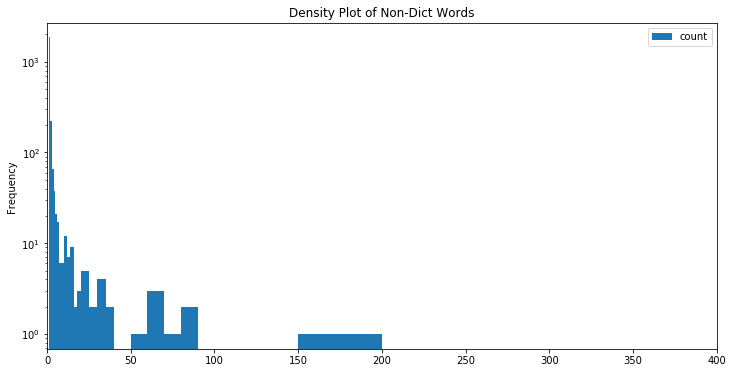

In [35]:
def check_non_dict(input_series):
    print_bold('Checking Non-dictionary Words...')
    non_dict = cleaner.non_dict(input_series,min_occurrence = 1)
    print('Non-Dictionary words found: ',len(non_dict))
    non_dict_df = pd.DataFrame(non_dict,columns=['word','count'])
    print('Statistic Description for Non-Dictionary words')
    print('-'*20)
    print(non_dict_df.describe())
    bins_set = [
        #(lower, upper, step),
        (0,10,1),
        (10,20,2),
        (20,50,5),
        (50,100,10),
        (100,450,50)
    ]
    bins = []
    for (l,u,s) in bins_set:
        bins = bins + list(range(l,u,s))
#     print(bins)
    ax = non_dict_df.plot.hist(figsize=(12,6),xlim=[0,400],bins=bins)
    ax.set_yscale('log')
    ax.set_title('Density Plot of Non-Dict Words')
    return non_dict
non_dict = check_non_dict(df_test)

In [55]:
# Inspect non_dict (first 10 elements)
non_dict[:10]

[('started', 172),
 ('seems', 89),
 ('others', 84),
 ('happened', 70),
 ('died', 68),
 ('asked', 67),
 ('called', 66),
 ('fucked', 55),
 ('talked', 37),
 ('failed', 35)]

#### Auto Correction

Auto Correcting...



Auto Corrected: 1848/2289
Tokenizing...



Cleaning Tokens...



Removing Stop Words...



Lemmatizing...



Translating...



Removing posts with less than 2 words...
15 posts removed:
57       [please]
200        [http]
323        [http]
439     [removed]
447        [hate]
509       [thank]
512       [title]
652       [going]
692        [dont]
760        [done]
860     [goodbye]
923        [http]
1186        [fun]
1190           []
1286           []
Name: text, dtype: object
Checking Non-dictionary Words...
Non-Dictionary words found:  957
Statistic Description for Non-Dictionary words
--------------------
            count
count  957.000000
mean     2.411703
std     12.955015
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max    379.000000


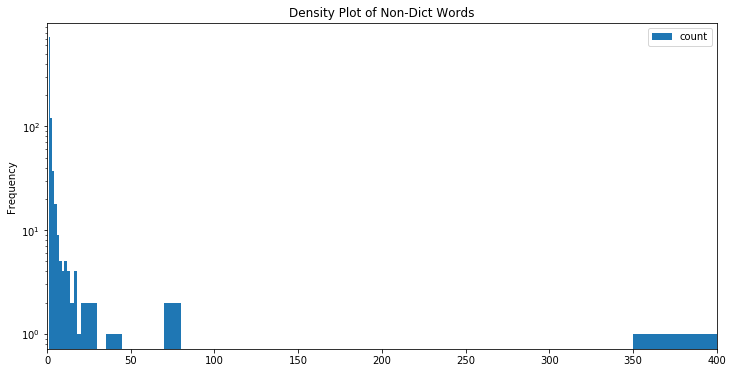

In [40]:
spell = Speller()
stemmer = nltk.stem.snowball.SnowballStemmer("english")
update_translate = {}
print_bold('Auto Correcting...')
for (word, count) in tqdm(non_dict):
    new_word = spell(stemmer.stem(word))
    if new_word != word:
        update_translate[word] = new_word
cleaner.update_custom_translate(update_translate)
print('Auto Corrected: %s/%s' % (len(update_translate),len(non_dict)))
test_df2 = cleaner.perform_clean(df)
non_dict2 = check_non_dict(test_df2)

In [58]:
#inspect autocorrect changes (up to 10 entries)
n = 10
i = 0
for (k,v) in update_translate.items():
    if i >= n:
        break
    print('%s ---> %s' %(k,v))
    i += 1

started ---> start
seems ---> seem
others ---> other
happened ---> happen
died ---> die
asked ---> ask
called ---> call
fucked ---> fuck
talked ---> talk
failed ---> fail


In [59]:
#inspect new non-dict words (up to 10 entries)
non_dict2[0:10]

[('im', 379),
 ('ive', 72),
 ('idk', 72),
 ('reddit', 41),
 ('etc', 37),
 ('became', 27),
 ('que', 27),
 ('bf', 23),
 ('cuz', 22),
 ('everytim', 19)]

#### Manual Correction

In [44]:
# define mannual correct function
def manual_correct(non_dict):
    print_bold('Manual Spelling Correction')
    instruction = '''
    Key in spelling correction and press [Enter] to update custom_translate
    use \exit to stop and save
    use \stop to add the word to custom stop list
    use \dict to add the word to custom dictionary
    ''' + '-'*30
    prev_print = None
    manual_translate = {}
    manual_stop = []
    manual_dict = []
    for (word, count) in non_dict:
        clear_output(wait=True)
        print(instruction)
        time.sleep(0.1)
        if prev_print:
            print(prev_print)
            time.sleep(0.1)
        user_input = input('Correction for (freq: %s) %s: ' % (count,word))
        if user_input == '\exit':
            break
        elif user_input == '\stop':
            manual_stop.append(word)
        elif user_input == '\dict':
            manual_dict.append(word)
        elif user_input == '':
            continue
        else:
            manual_translate[word] = user_input.strip()
        prev_print = 'Correction for (freq: %s) %s: ' % (count,word) + user_input
    cleaner.update_custom_translate(manual_translate)
    cleaner.update_custom_stop(manual_stop)
    cleaner.update_custom_dict(manual_dict)
    print('Updated Correction: ',len(manual_translate))
    print(manual_translate)
    print('-'*30)
    print('Updated Stop Words: ',len(manual_stop))
    print(manual_stop)
    print('-'*30)
    print('Update Dictionary: ',len(manual_dict))
    print(manual_dict)
    print('-'*30)


    Key in spelling correction and press [Enter] to update custom_translate
    use \exit to stop and save
    use \stop to add the word to custom stop list
    use \dict to add the word to custom dictionary
    ------------------------------
Correction for (freq: 3) nowi: \stop
Correction for (freq: 3) pre: \exit
Updated Correction:  22
{'everytim': 'everytime', 'uni': 'university', 'dr': 'doctor', 'noone': 'none', 'fck': 'fuck', 'hardest': 'hard', 'pls': 'please', 'soo': 'so', 'manipul': 'manipulate', 'por': 'poor', 'ppl': 'people', 'blew': 'blow', 'app': 'application', 'died': 'die', 'louder': 'loud', 'reli': 'rely', 'deeper': 'deep', 'refs': 'reference', 'recaps': '\\recap', 'darkest': 'dark', 'smallest': 'small', 'fullest': 'full'}
------------------------------
Updated Stop Words:  49
['im', 'ive', 'idk', 'reddit', 'etc', 'que', 'cuz', 'lol', 'alot', 'df', 'subreddit', 'tbh', 'couldnt', 'shes', 'iti', 'isnt', 'não', 'wtf', 'btw', 'haha', 'yall', 'atleast', 'snapchat', 'youtube',


Cleaning Tokens...



Removing Stop Words...



Lemmatizing...



Translating...



Removing posts with less than 2 words...
15 posts removed:
57       [please]
200        [http]
323        [http]
439     [removed]
447        [hate]
509       [thank]
512       [title]
652       [going]
692        [dont]
760        [done]
860     [goodbye]
923        [http]
1186        [fun]
1190           []
1286           []
Name: text, dtype: object
Checking Non-dictionary Words...
Non-Dictionary words found:  888
Statistic Description for Non-Dictionary words
--------------------
            count
count  888.000000
mean     1.263514
std      0.837628
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     19.000000


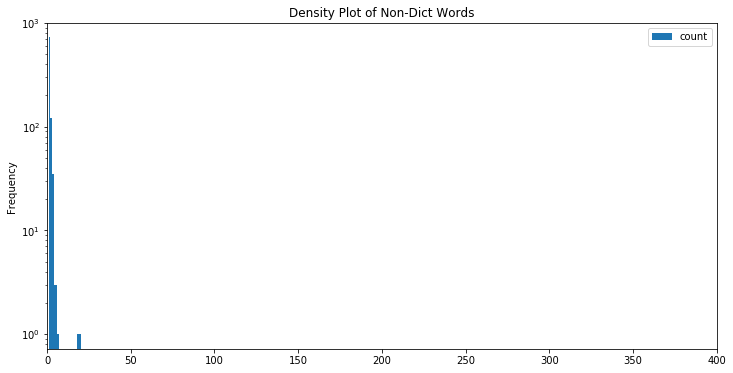

In [47]:
# for recursive correction purpose
try:
    non_dict3
except NameError:
    non_dict3 = None
if non_dict3 is None:
    non_dict3 = non_dict2
    
# start manual correction
manual_correct(non_dict3)
test_df3 = cleaner.perform_clean(df)
non_dict3 = check_non_dict(test_df3)

repeat manual correction to annotate more data

### Results

In [48]:
df_clean = test_df3 # Use the final df
df_clean

0       [fucking, hate, holiday, season, first, thanks...
1          [dm, add, discord, want, help, talk, cofactor]
2       [nearly, always, battled, depression, got, old...
3       [future, nothing, impenetrable, fog, look, bac...
4       [always, fighting, sister, always, lash, mom, ...
                              ...                        
1293    [since, felt, depressed, almost, took, life, w...
1294    [nt, know, reaching, time, seem, appropriate, ...
1295    [dont, believe, afterlife, stay, night, fear, ...
1296    [nt, think, actually, kill, thats, scared, nt,...
1297    [wan, na, die, badly, everytim, hear, someone,...
Name: text, Length: 1283, dtype: object

## Organizing The Data

* Corpus - collection of texts
* Document-Term Matrix - word counts in matrix format

#### Document-Term Matrix

The text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.

In [50]:
# Create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')  # remove stop words from the build-in CountVectorizer
data_cv = cv.fit_transform(df_clean.apply(lambda x: ' '.join(x)))
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data_dtm.index = df_clean.index
data_dtm

,aaa,ab,abandon,abandoned,abd,abdomen,abdominal,ability,ablaze,able,...,zero,zimbabwe,ziplock,zombie,zone,zoning,zoo,zoom,zopiclon,última
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# inpect feature_names (up to 10 entries)
cv.get_feature_names()[0:10]

['aaa',
 'ab',
 'abandon',
 'abandoned',
 'abd',
 'abdomen',
 'abdominal',
 'ability',
 'ablaze',
 'able']

#### Storing results

In [52]:
# Pickle it for later use


data_dtm.to_pickle("pickles/dtm.pkl") # document-term matrix
df_clean.to_pickle("pickles/df_clean.pkl") # After text cleaning
df.to_pickle("pickles/df.pkl") # Before Text Cleaning
pickle.dump(cv, open("pickles/cv.pkl", "wb")) #CountVectorize Object

In [1]:
# Convert notebook to html
!jupyter nbconvert --to html_ch --output-dir='.\html' "1. Data Cleaning.ipynb"

[NbConvertApp] Converting notebook 1. Data Cleaning.ipynb to html_ch
[NbConvertApp] Writing 453306 bytes to .\html\1. Data Cleaning.html


# --------------------------------------------------END---------------------------------------------------------